# This notebook takes a chart of all of the energy-parameters used in the fits: priors, posteriors, and theoretical values

In [1]:
import numpy as np
import gvar as gv
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

In [2]:
import pickle


In [3]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [4]:
def Ei_FH(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec):
        Ea += p['dE{}'.format(l)]
        
    Ea += p['FH_dEmax']
    
    return Ea

In [5]:
# This method is copied from StackOverFlow, courtesy of tmdavison (https://stackoverflow.com/questions/37852462/filled-errorbars-in-matplotlib-rectangles/37852631)
def makeErrorBoxes(xdata,ydata,xerror,yerror,fc=None,ec='None',alpha=0.3, legendlabel=None):
    
    if fc is None:
        fc = np.array(['red' for i in xdata])
    
    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for xc,yc,xe,ye,ci in zip(xdata,ydata,xerror.T,yerror.T,fc):
        rect = Rectangle((xc-xe[0],yc-ye[0]),xe.sum(),ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes,alpha=alpha,edgecolor=ec, facecolor=fc, label = legendlabel)
    #if legendlabel is not None:
        #pc.set_label(legendlabel)
    
    # Add collection to axes
    ax.add_collection(pc)
    ax.legend(loc = 'upper right')

In [6]:
# Create all of the lines for the model
colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey', 'tab:brown', 'tab:pink', 'tab:olive'])

mpi = 0.1885
num_models = 12

x_model = np.linspace(-1.5, 6.5, 1000)
models = np.array([np.array([0.665 for x in x_model])])
mpi2_dataset = np.array([np.array([mpi*2 for x in x_model])])
labels = np.array(["ground"])

for i in range(num_models):
    models = np.append(models, np.array([models[i]])+mpi2_dataset, axis = 0)
    labels = np.append(labels, "ground + {}*mpi".format(2*(i+1)))
    

## Define a method for doing the graphing

In [7]:
# Precondition: you must define the figure and the axes before every time you call the function
# Example:
#fig = plt.figure(figsize=(12, 10))
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
def spectrum_graph(num_zs, num_states_FH, in_filename, out_filename, graphtitle, b):
    # Set priors
    priors = gv.BufferDict()

    priors['E0'] = gv.gvar(0.665, 0.015)
    # Use constant dE to prior the energies
    dE0 = 2*mpi
    energyvals = np.array([None]*num_zs)
    dEvals = np.array([None]*(num_zs - 1))

    #E0_errbar = 0.8
    energyvals[0] = priors['E0'].mean
    for k in range(1, num_zs):
        dEvals[k-1] = dE0
        energyvals[k] = energyvals[k-1] + dEvals[k-1]
    
    for k in range(1, num_zs):
        priors['log(dE{})'.format(k)] = gv.gvar(np.log(dEvals[k-1]), b)
    
    priors['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 1]), b)
    
    energies_prior = gv.BufferDict()

    energies_prior['E0'] = priors['E0']
    for k in range(1, num_zs):
        energies_prior['E{}'.format(k)] = Ei(k, priors)
    
    prior_xval = np.array([k for k in range(num_zs)])
    prior_xval_err = np.array([[0.5 for k in range(num_zs)], [0.5 for k in range(num_zs)]])
    prior_yval = np.array([energies_prior['E{}'.format(k)].mean for k in range(num_zs)])
    prior_yval_err = np.array([[energies_prior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_prior['E{}'.format(k)].sdev for k in range(num_zs)]])
    
    if num_states_FH != 0:
        prior_FH_xval = np.array([-1])
        prior_FH_xval_err = np.array([[0.5], [0.5]])
        E_FH_prior = energies_prior['E{}'.format(num_states_FH-2)]+priors['FH_dEmax']
        prior_FH_yval = np.array([E_FH_prior.mean])
        prior_FH_yval_err = np.array([[E_FH_prior.sdev], [E_FH_prior.sdev]])

        prior_xval = np.append(prior_xval, prior_FH_xval, axis=0)
        prior_xval_err = np.array([np.append(prior_xval_err[0], prior_FH_xval_err[0]), np.append(prior_xval_err[1], prior_FH_xval_err[1])])
        #prior_xval_err[0] = np.append(prior_xval_err[0], prior_FH_xval_err[0])
        #prior_xval_err[1] = np.append(prior_xval_err[1], prior_FH_xval_err[1])
        prior_yval = np.append(prior_yval, prior_FH_yval, axis=0)
        prior_yval_err = np.array([np.append(prior_yval_err[0], prior_FH_yval_err[0]), np.append(prior_yval_err[1], prior_FH_yval_err[1])])
        #prior_yval_err[0] = np.append(prior_yval_err[0], prior_FH_yval_err[0])
        #prior_yval_err[1] = np.append(prior_yval_err[1], prior_FH_yval_err[1])
        
    # Load in the posteriors
    posterior_file = open(in_filename, 'rb')
    posteriors = pickle.load(posterior_file)
    posterior_file.close()

    energies_posterior = gv.BufferDict()

    energies_posterior['E0'] = posteriors['E0']
    for k in range(1, num_zs):
        energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
    posterior_xval = np.array([k for k in range(num_zs)])
    posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
    posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
    posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])
    
    if num_states_FH != 0:
        posterior_FH_xval = np.array([-1])
        posterior_FH_xval_err = np.array([[0.5], [0.5]])
        E_FH_posterior = energies_posterior['E{}'.format(num_states_FH-2)]+posteriors['FH_dEmax']
        posterior_FH_yval = np.array([E_FH_posterior.mean])
        posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

        posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
        posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
        posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
        posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])

    xlim_upper = num_zs - 0.5
    xtick_nums = np.array([num_zs - i for i in range(num_zs + 1)])
    xtick_strings = np.array(["E{}".format(n) for n in xtick_nums])
    
    if num_states_FH != 0:
        xlim_lower = -1.5
        xtick_nums = np.append(xtick_nums, -1)
        xtick_strings = np.append(xtick_strings, "E_FH")
    
    else:
        xlim_lower = -0.5
    
    #ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

    #plots_patches = []
    for i in range(1, num_models + 1):
        #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
        ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

    ax.set_title(graphtitle)
    ax.set_xticks(xtick_nums)
    ax.set_xticklabels(xtick_strings)

    priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
    posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
    plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]
    
    print(posterior_xval)
    print(posterior_yval)
    print(posterior_xval_err)
    print(posterior_yval_err)
    makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey' for i in range(len(xtick_nums))], legendlabel="prior")
    makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red' for i in range(len(xtick_nums))], legendlabel="posterior")

    legend_objects = [priorpatch, posteriorpatch]
    legend_labels = ["prior", "posterior"]
    for i in range(1, num_models + 1):
        legend_objects.append(plots_patch[i])
        legend_labels.append(labels[i])

    plt.legend(loc='upper right')
    plt.legend(legend_objects, legend_labels)
    plt.ylim([0.5, 4.7])
    ax.set_xlim([xlim_upper, xlim_lower])
    plt.savefig(out_filename)
    
    plt.show()
    
    
    plt.clf()

### Chained 2pt-3pt fit

[0 1 2 3 4 5]
[0.65891527 1.0033999  1.48291803 1.92572442 2.37155714 2.77083218]
[[0.4 0.4 0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4 0.4]]
[[0.0028531  0.06482031 0.15033415 0.23018491 0.27830509 0.23913664]
 [0.0028531  0.06482031 0.15033415 0.23018491 0.27830509 0.23913664]]


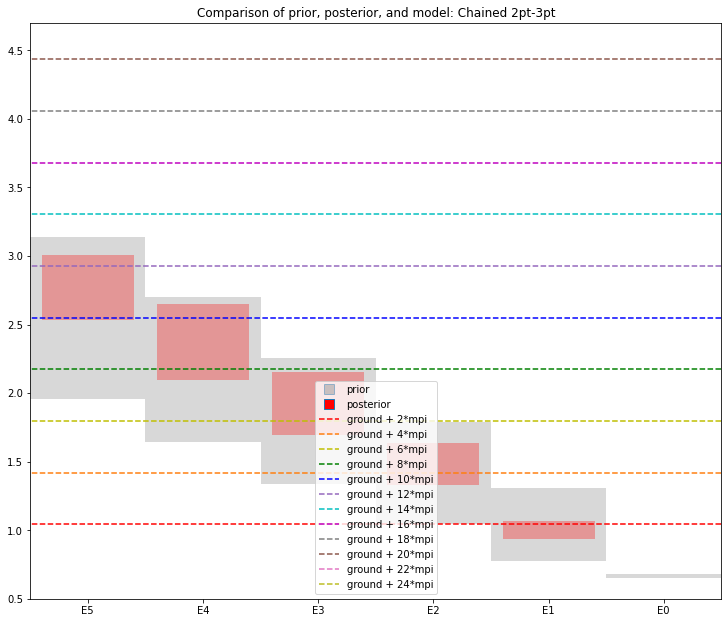

[0 1 2 3]
[0.66084025 1.08339261 1.52089709 2.13570335]
[[0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4]]
[[0.00266372 0.04670613 0.15658789 0.25570165]
 [0.00266372 0.04670613 0.15658789 0.25570165]]


<Figure size 432x288 with 0 Axes>

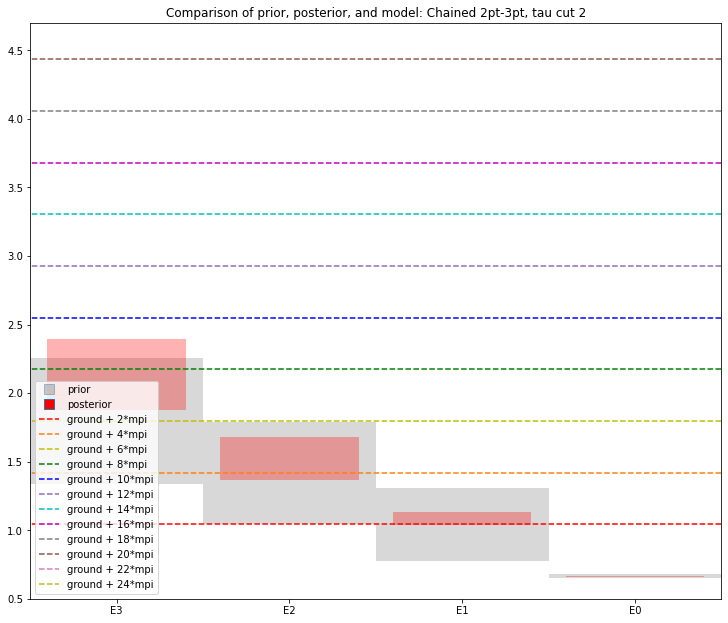

[ 0  1  2  3  4  5  6 -1]
[0.66163835 0.93847466 1.20406456 1.810524   2.4274891  3.04026202
 3.61200459 1.53240482]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00351951 0.07143932 0.10601035 0.20669275 0.33063276 0.44388174
  0.50045995 0.08583507]
 [0.00351951 0.07143932 0.10601035 0.20669275 0.33063276 0.44388174
  0.50045995 0.08583507]]


<Figure size 432x288 with 0 Axes>

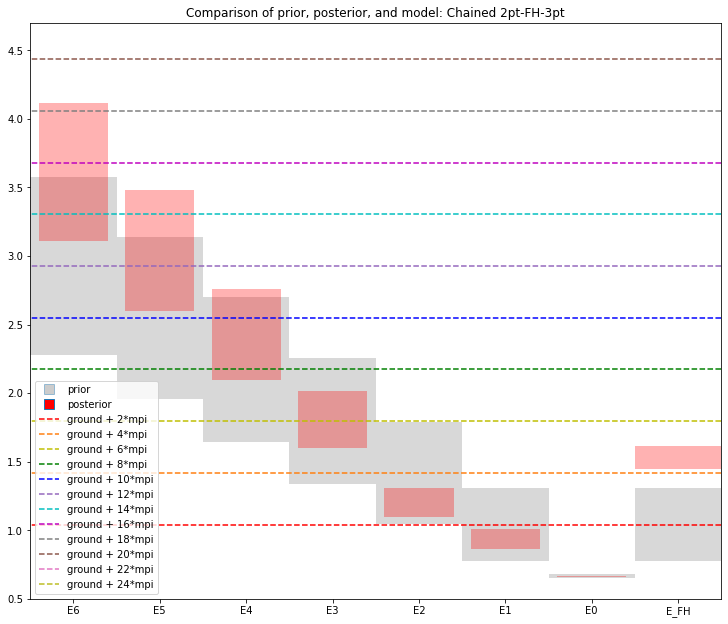

[ 0  1  2  3 -1]
[0.66129557 1.09253329 1.52107434 2.16296261 1.7498132 ]
[[0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.5]]
[[0.00254277 0.04040678 0.1418586  0.24573371 0.26397205]
 [0.00254277 0.04040678 0.1418586  0.24573371 0.26397205]]


<Figure size 432x288 with 0 Axes>

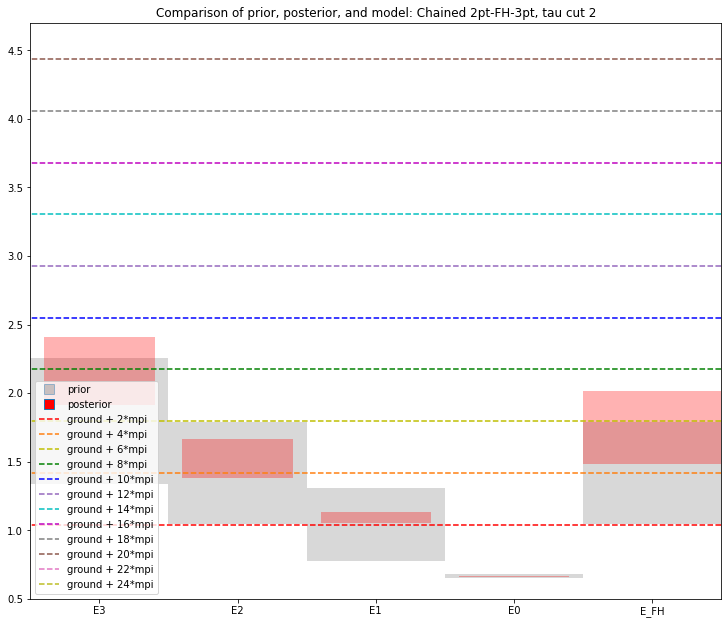

<Figure size 432x288 with 0 Axes>

In [9]:

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 0, 'chained_2pt_3pt_Final.obj', 'chained_2pt_3pt_tau1_noFH.png', "Comparison of prior, posterior, and model: Chained 2pt-3pt", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(4, 0, 'chained_2pt_3pt_tau2_Final.obj', 'chained_2pt_3pt_tau2_noFH.png', "Comparison of prior, posterior, and model: Chained 2pt-3pt, tau cut 2", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(7, 2, 'chained_2pt_3pt_withFH_Final.obj', 'chained_2pt_3pt_tau1_withFH.png', "Comparison of prior, posterior, and model: Chained 2pt-FH-3pt", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(4, 3, 'chained_2pt_3pt_tau2_withFH_Final.obj', 'chained_2pt_3pt_tau2_withFH.png', "Comparison of prior, posterior, and model: Chained 2pt-FH-3pt, tau cut 2", 0.7)


### Simultaneous 2pt-3pt fit

[0 1 2 3 4 5 6]
[0.65759129 0.80664653 1.15693719 1.61331877 2.25305986 2.92644084
 3.94684162]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4]]
[[0.00709624 0.10074451 0.11899332 0.18986389 0.33396475 0.41453778
  0.64143306]
 [0.00709624 0.10074451 0.11899332 0.18986389 0.33396475 0.41453778
  0.64143306]]


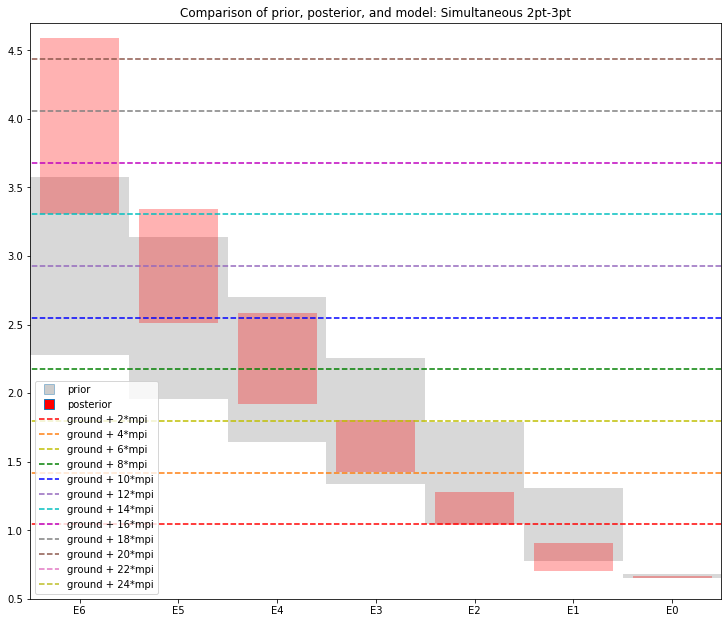

[0 1 2 3]
[0.65097009 0.80534881 1.26333953 1.63422567]
[[0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4]]
[[0.00920345 0.06396544 0.09871084 0.04909083]
 [0.00920345 0.06396544 0.09871084 0.04909083]]


<Figure size 432x288 with 0 Axes>

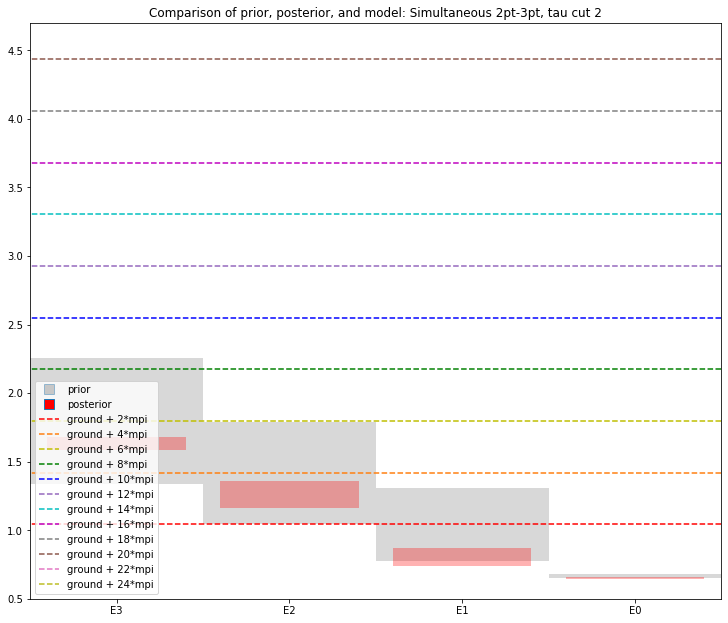

[ 0  1  2  3  4  5  6 -1]
[0.66133237 1.07956768 1.62746265 1.97328208 2.72931789 3.79133188
 4.33122541 1.75280712]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00278957 0.06017049 0.15011962 0.17615972 0.3878772  0.58625938
  0.62950996 0.03021608]
 [0.00278957 0.06017049 0.15011962 0.17615972 0.3878772  0.58625938
  0.62950996 0.03021608]]


<Figure size 432x288 with 0 Axes>

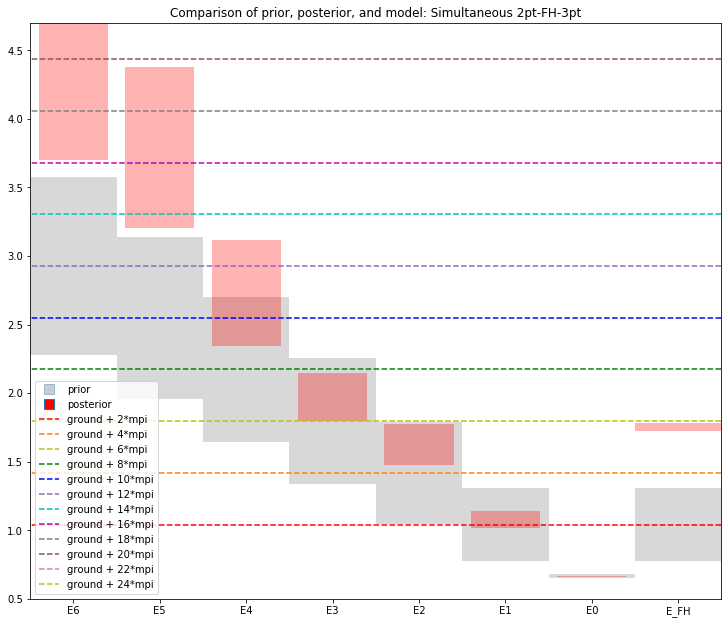

[ 0  1  2  3 -1]
[0.65609928 0.90619741 1.31592723 1.91902152 1.50249029]
[[0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.5]]
[[0.00555407 0.09714093 0.1406719  0.19788407 0.08842827]
 [0.00555407 0.09714093 0.1406719  0.19788407 0.08842827]]


<Figure size 432x288 with 0 Axes>

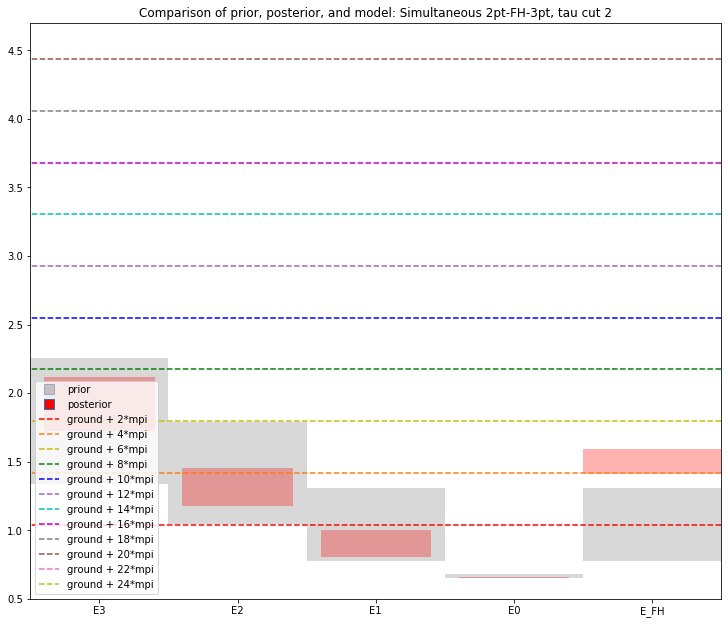

<Figure size 432x288 with 0 Axes>

In [42]:

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(7, 0, 'simul2pt3pt_n5_out.obj', 'simultaneous_2pt_3pt_tau1_noFH.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-3pt", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(4, 0, 'simul2pt3pt_tau2_n4_out.obj', 'simultaneous_2pt_3pt_tau2_noFH.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-3pt, tau cut 2", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(7, 2, 'simul2pt3pt_n5_withFH_out.obj', 'simultaneous_2pt_3pt_tau1_withFH.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-FH-3pt", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(4, 2, 'simul2pt3pt_tau2_withFH_n4_out.obj', 'simultaneous_2pt_3pt_tau2_withFH.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-FH-3pt, tau cut 2", 0.7)



### Chained 2pt-sumsub-3pt fit

[ 0  1  2  3  4  5 -1]
[0.66167698 1.01119706 1.51455503 1.92491869 2.69288506 4.08481353
 1.46432875]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00343923 0.0670803  0.1226439  0.17709444 0.31959522 0.53990511
  0.24916214]
 [0.00343923 0.0670803  0.1226439  0.17709444 0.31959522 0.53990511
  0.24916214]]


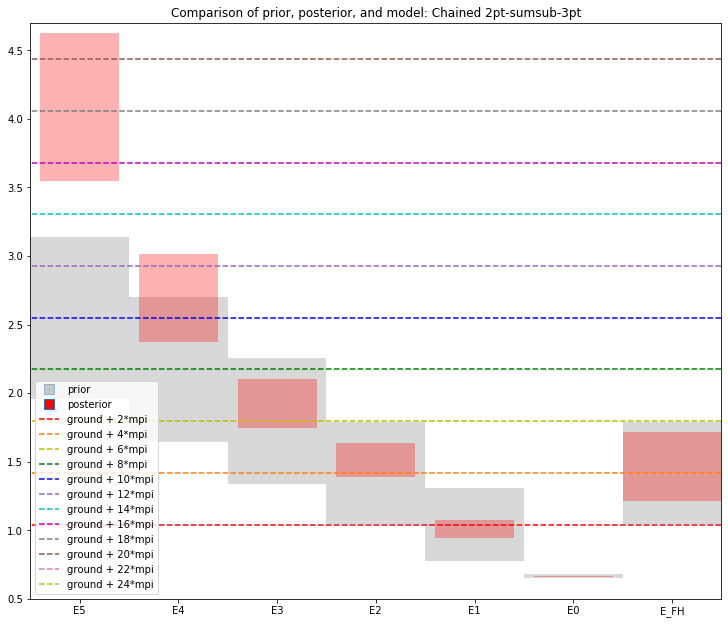

[ 0  1  2  3 -1]
[0.65925585 1.06276009 2.13508954 2.87576852 1.46985767]
[[0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.5]]
[[0.00231638 0.03356606 0.08148265 0.27885245 0.20535496]
 [0.00231638 0.03356606 0.08148265 0.27885245 0.20535496]]


<Figure size 432x288 with 0 Axes>

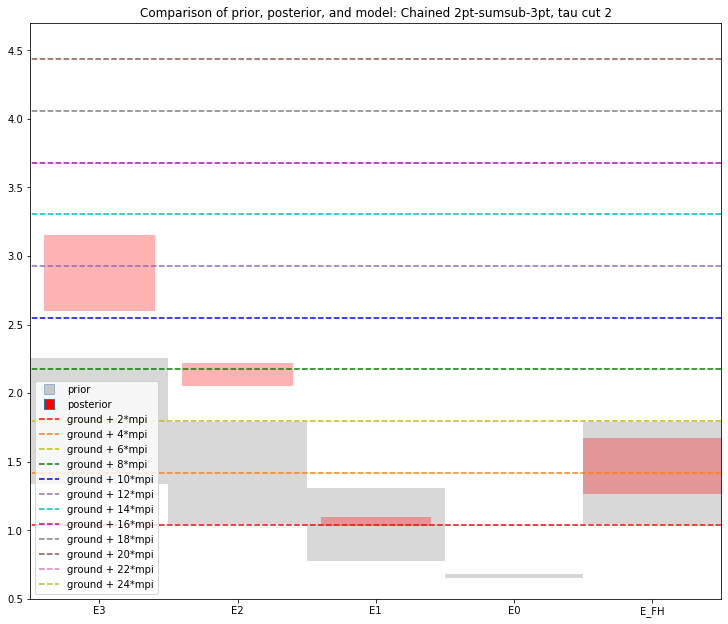

[ 0  1  2  3  4  5  6 -1]
[0.66145328 0.92077078 1.19808925 1.63923633 2.17224944 2.84228715
 3.91065706 1.48706062]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00345451 0.06904126 0.10892073 0.19994884 0.29804968 0.38521071
  0.53626325 0.03233134]
 [0.00345451 0.06904126 0.10892073 0.19994884 0.29804968 0.38521071
  0.53626325 0.03233134]]


<Figure size 432x288 with 0 Axes>

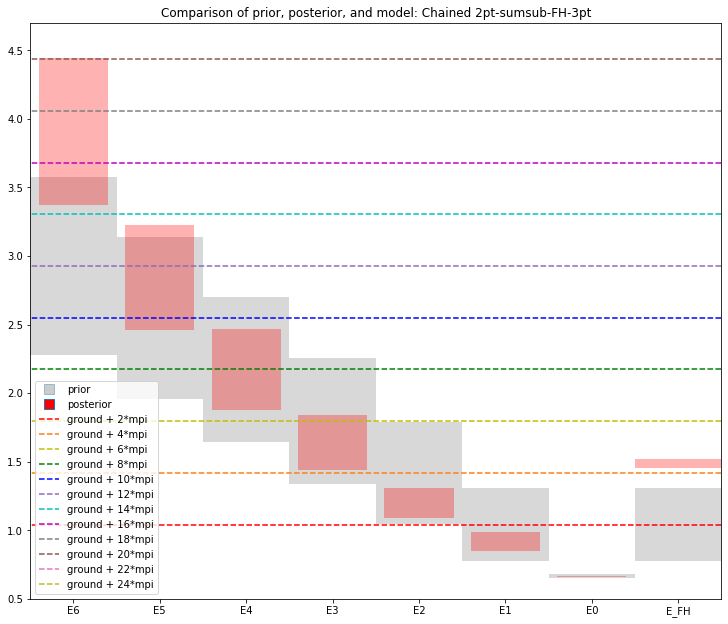

[ 0  1  2  3 -1]
[0.65985368 1.07455489 2.07503015 2.79879336 1.75152831]
[[0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.5]]
[[0.00217711 0.02919179 0.07801807 0.26707868 0.10422277]
 [0.00217711 0.02919179 0.07801807 0.26707868 0.10422277]]


<Figure size 432x288 with 0 Axes>

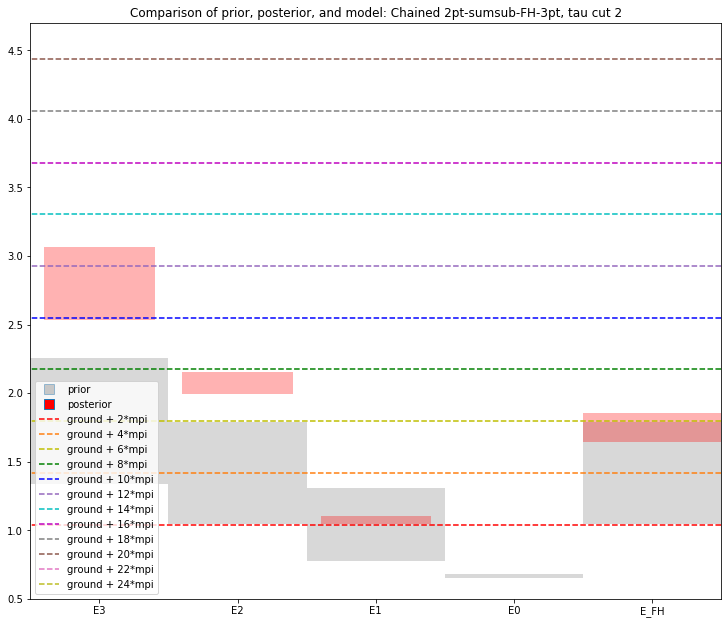

<Figure size 432x288 with 0 Axes>

In [43]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, "Final(3pt)_out.obj", 'chained_2pt_sumsub_3pt_tau1.png', "Comparison of prior, posterior, and model: Chained 2pt-sumsub-3pt", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(4, 3, 'Final(3pt)_tau2_out.obj', 'chained_2pt_sumsub_3pt_tau2.png', "Comparison of prior, posterior, and model: Chained 2pt-sumsub-3pt, tau cut 2", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(7, 2, 'Final(3pt)_withFH_out.obj', 'chained_2pt_sumsub_FH_3pt_tau1.png', "Comparison of prior, posterior, and model: Chained 2pt-sumsub-FH-3pt", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(4, 3, 'Final(3pt)_tau2_withFH_out.obj', 'chained_2pt_sumsub_FH_3pt_3pt_tau2.png', "Comparison of prior, posterior, and model: Chained 2pt-sumsub-FH-3pt, tau cut 2", 0.7)



[ 0  1  2  3  4  5  6 -1]
[0.6604685  1.12306215 1.37055084 2.08467159 2.58963948 3.41415398
 4.21076665 1.12978497]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00078695 0.03930462 0.10801632 0.18068503 0.52794281 0.5946647
  0.76852928 0.0311599 ]
 [0.00078695 0.03930462 0.10801632 0.18068503 0.52794281 0.5946647
  0.76852928 0.0311599 ]]


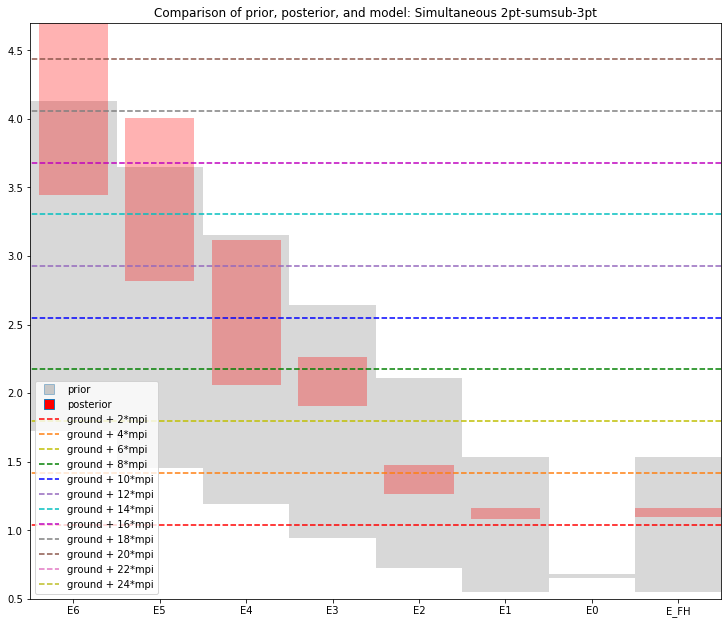

[ 0  1  2  3 -1]
[0.65187936 0.78233865 1.25892108 1.64450966 1.39321067]
[[0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.5]]
[[0.00991414 0.06505689 0.08795769 0.04442922 0.05340838]
 [0.00991414 0.06505689 0.08795769 0.04442922 0.05340838]]


<Figure size 432x288 with 0 Axes>

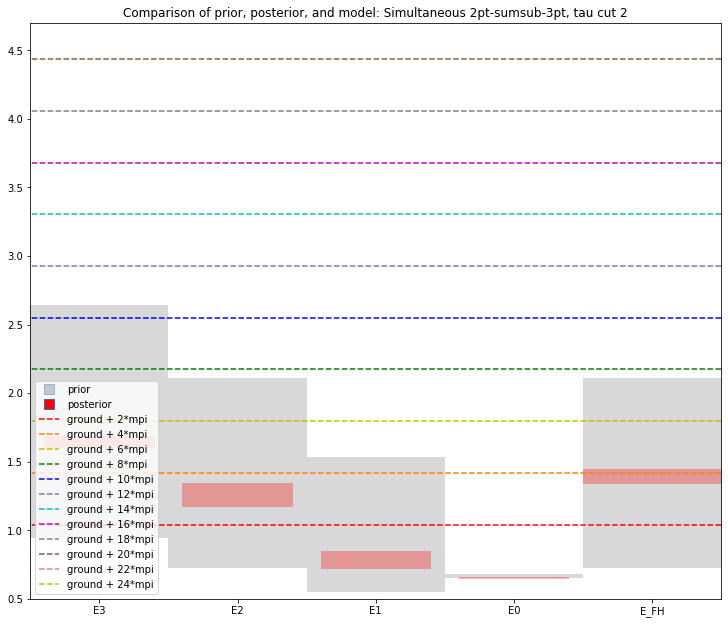

[ 0  1  2  3  4  5  6 -1]
[0.65890471 1.00772666 1.35589012 1.82463722 2.63771317 3.45177395
 4.33671528 1.70969704]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00088078 0.07848577 0.14355594 0.16559768 0.55350127 0.82789228
  0.85086327 0.23645328]
 [0.00088078 0.07848577 0.14355594 0.16559768 0.55350127 0.82789228
  0.85086327 0.23645328]]


<Figure size 432x288 with 0 Axes>

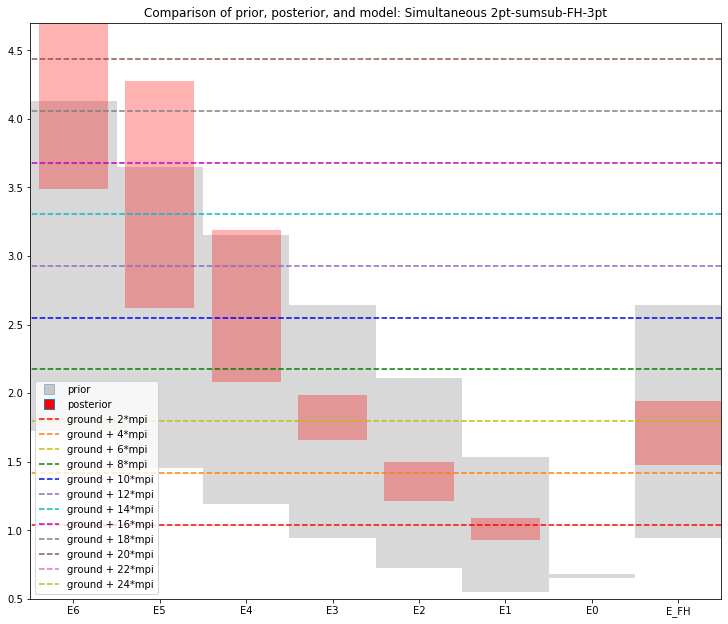

[ 0  1  2  3 -1]
[0.66109151 0.94112334 1.09504183 1.6936075  1.31674548]
[[0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.5]]
[[0.00339815 0.08271719 0.0345248  0.02604361 0.04942306]
 [0.00339815 0.08271719 0.0345248  0.02604361 0.04942306]]


<Figure size 432x288 with 0 Axes>

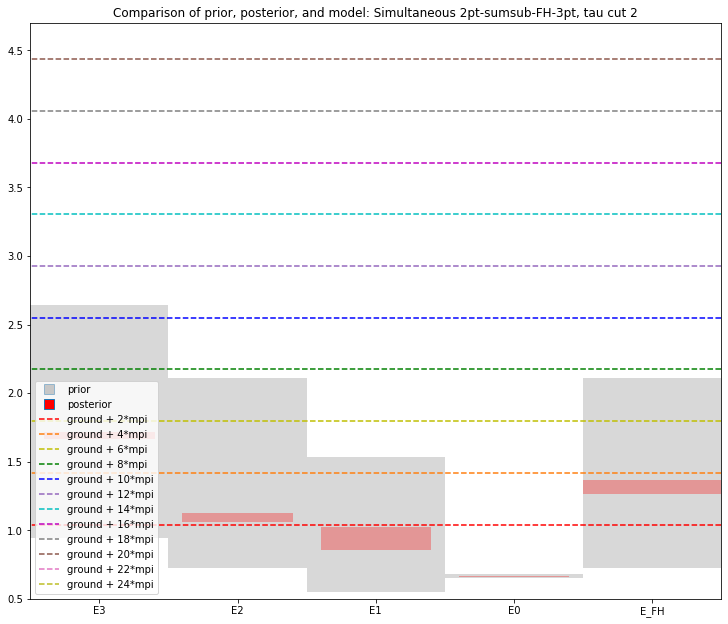

<Figure size 432x288 with 0 Axes>

In [44]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(7, 2, "all_postchained_out.obj", 'simultaneous_2pt_sumsub_3pt_tau1.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-sumsub-3pt", 1.3)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(4, 3, 'all_postchained_out_tau2.obj', 'simultaneous_2pt_sumsub_3pt_tau2.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-sumsub-3pt, tau cut 2", 1.3)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(7, 4, 'all_postchained_withFH_out.obj', 'simultaneous_2pt_sumsub_FH_3pt_tau1.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-sumsub-FH-3pt", 1.3)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(4, 3, 'all_postchained_withFH_tau_out.obj', 'simultaneous_2pt_sumsub_FH_3pt_tau2.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-sumsub-FH-3pt, tau cut 2", 1.3)


In [29]:
# Now, set priors
num_zs = 7
num_states_FH = 2

priors = gv.BufferDict()

priors['E0'] = gv.gvar(0.665, 0.015)
# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = priors['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0
    energyvals[k] = energyvals[k-1] + dEvals[k-1]
    
for k in range(1, num_zs):
    priors['log(dE{})'.format(k)] = gv.gvar(np.log(dEvals[k-1]), 0.7)
    
priors['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)
    
energies_prior = gv.BufferDict()

energies_prior['E0'] = priors['E0']
for k in range(1, num_zs):
    energies_prior['E{}'.format(k)] = Ei(k, priors)
    
prior_xval = np.array([k for k in range(num_zs)])
prior_xval_err = np.array([[0.5 for k in range(num_zs)], [0.5 for k in range(num_zs)]])
prior_yval = np.array([energies_prior['E{}'.format(k)].mean for k in range(num_zs)])
prior_yval_err = np.array([[energies_prior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_prior['E{}'.format(k)].sdev for k in range(num_zs)]])

prior_FH_xval = np.array([-1])
prior_FH_xval_err = np.array([[0.5], [0.5]])
E_FH_prior = priors['E{}'.format(num_states_FH-2)]+priors['FH_dEmax']
prior_FH_yval = np.array([E_FH_prior.mean])
prior_FH_yval_err = np.array([[E_FH_prior.sdev], [E_FH_prior.sdev]])

prior_xval = np.append(prior_xval, prior_FH_xval, axis=0)
prior_xval_err = np.array([np.append(prior_xval_err[0], prior_FH_xval_err[0]), np.append(prior_xval_err[1], prior_FH_xval_err[1])])
#prior_xval_err[0] = np.append(prior_xval_err[0], prior_FH_xval_err[0])
#prior_xval_err[1] = np.append(prior_xval_err[1], prior_FH_xval_err[1])
prior_yval = np.append(prior_yval, prior_FH_yval, axis=0)
prior_yval_err = np.array([np.append(prior_yval_err[0], prior_FH_yval_err[0]), np.append(prior_yval_err[1], prior_FH_yval_err[1])])
#prior_yval_err[0] = np.append(prior_yval_err[0], prior_FH_yval_err[0])
#prior_yval_err[1] = np.append(prior_yval_err[1], prior_FH_yval_err[1])

### Chained 2-pt-3pt-FH

In [83]:
# tau 1, no FH
num_zs = 5
# Now, retrieve posteriors
posterior_file = open("Final(CFH)_out.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])

posterior_FH_xval = np.array([-1])
posterior_FH_xval_err = np.array([[0.5], [0.5]])
E_FH_posterior = posteriors['E{}'.format(num_states_FH-2)]+posteriors['FH_dEmax']
posterior_FH_yval = np.array([E_FH_posterior.mean])
posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])




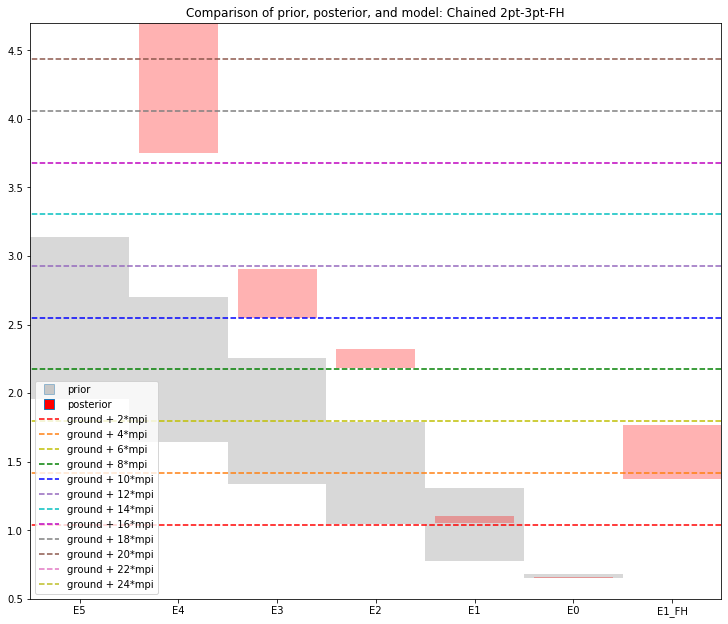

In [84]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Chained 2pt-3pt-FH")
ax.set_xlim([5.5, -1.5])
ax.set_xticks([5, 4, 3, 2, 1, 0, -1])
ax.set_xticklabels(["E5", "E4", "E3", "E2", "E1", "E0", "E{}_FH".format(num_states_FH - 1)])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 4.7])
plt.show()

#### g_A_{00} = 1.23 +/- 0.01                
#### g_V_{00} = 1.019 +/- 0.004

In [85]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)

gA_00 =  1.2325162868583106 +/- 0.010578584857666874
gV_00 =  1.0188195393320407 +/- 0.0037475501722552965


### Chained 2-pt-FH-3pt

In [86]:
# Now, retrieve posteriors
num_zs = 6
num_states_FH = 3
posterior_file = open("Final(3pt)_out.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])

posterior_FH_xval = np.array([-1])
posterior_FH_xval_err = np.array([[0.5], [0.5]])
E_FH_posterior = posteriors['E{}'.format(num_states_FH-3)]+posteriors['dE1']+posteriors['FH_dEmax']
posterior_FH_yval = np.array([E_FH_posterior.mean])
posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])



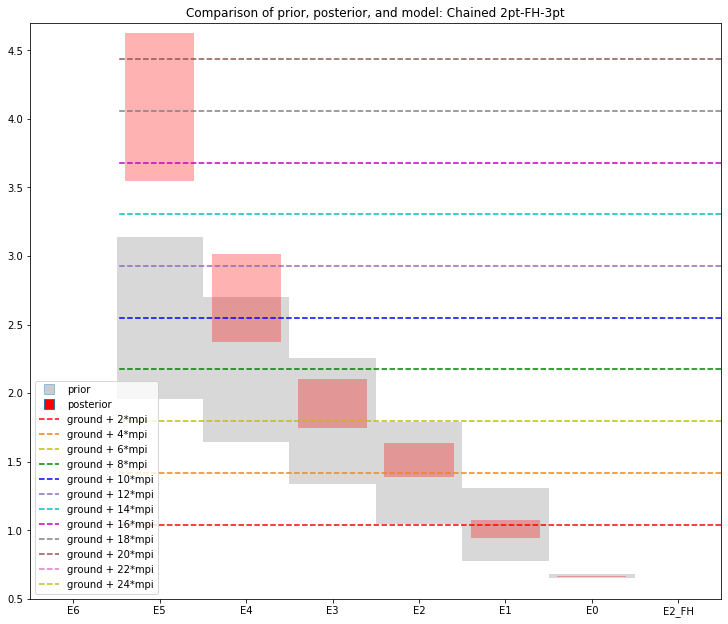

In [87]:

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Chained 2pt-FH-3pt")
ax.set_xlim([6.5, -1.5])
ax.set_xticks([6, 5, 4, 3, 2, 1, 0, -1])
ax.set_xticklabels(["E6", "E5", "E4", "E3", "E2", "E1", "E0", "E{}_FH".format(num_states_FH - 1)])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 4.7])
plt.show()


#### g_A_{00} = 1.23 +/- 0.01                
#### g_V_{00} = 1.019 +/- 0.004

In [42]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)


gA_00 =  1.2576637895135507 +/- 0.021765946261230903
gV_00 =  1.0223761295794218 +/- 0.01609374283979755


In [46]:
# tau 1, no FH

# Now, retrieve posteriors
posterior_file = open("Final(CFH)_out.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])

posterior_FH_xval = np.array([-1])
posterior_FH_xval_err = np.array([[0.5], [0.5]])
E_FH_posterior = posteriors['E{}'.format(num_states_FH-2)]+posteriors['FH_dEmax']
posterior_FH_yval = np.array([E_FH_posterior.mean])
posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])




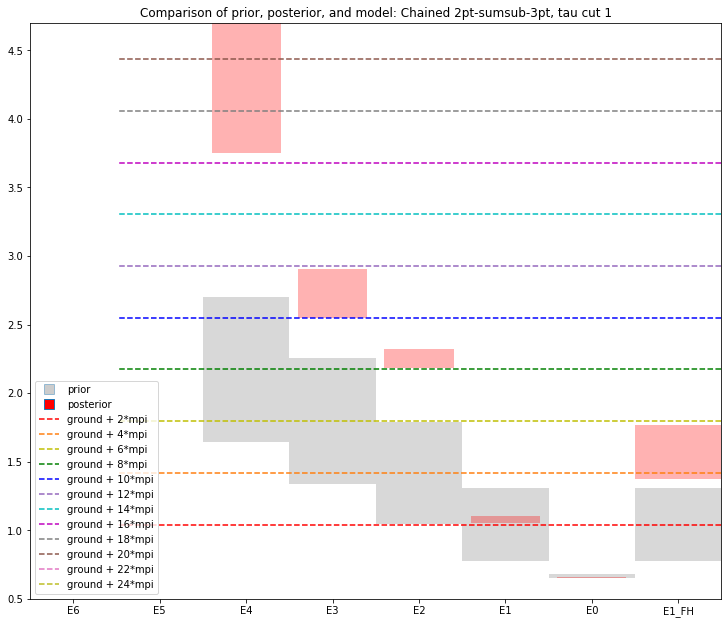

In [47]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Chained 2pt-sumsub-3pt, tau cut 1")
ax.set_xlim([6.5, -1.5])
ax.set_xticks([6, 5, 4, 3, 2, 1, 0, -1])
ax.set_xticklabels(["E6", "E5", "E4", "E3", "E2", "E1", "E0", "E{}_FH".format(num_states_FH - 1)])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 4.7])
plt.show()

#### g_A_{00} = 1.23 +/- 0.01                
#### g_V_{00} = 1.019 +/- 0.004

In [48]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)

gA_00 =  1.2325162868583106 +/- 0.010578584857666874
gV_00 =  1.0188195393320407 +/- 0.0037475501722552965


In [49]:
# tau 2, no FH
num_zs = 4
# Now, retrieve posteriors
posterior_file = open("Final(3pt)_tau2_out.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])

posterior_FH_xval = np.array([-1])
posterior_FH_xval_err = np.array([[0.5], [0.5]])
E_FH_posterior = posteriors['E{}'.format(num_states_FH-2)]+posteriors['FH_dEmax']
posterior_FH_yval = np.array([E_FH_posterior.mean])
posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])




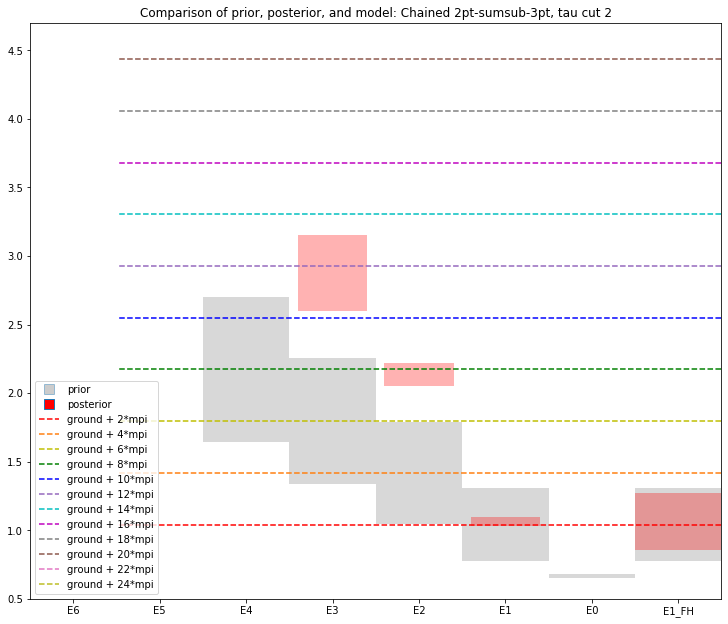

In [50]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Chained 2pt-sumsub-3pt, tau cut 2")
ax.set_xlim([6.5, -1.5])
ax.set_xticks([6, 5, 4, 3, 2, 1, 0, -1])
ax.set_xticklabels(["E6", "E5", "E4", "E3", "E2", "E1", "E0", "E{}_FH".format(num_states_FH - 1)])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 4.7])
plt.show()

#### g_A_{00} =         
#### g_V_{00} = 

In [51]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)

gA_00 =  1.2292383655063448 +/- 0.013381949352386681
gV_00 =  1.0128488941718445 +/- 0.003507470489991083


In [52]:
# tau 1, FH
num_zs = 7
# Now, retrieve posteriors
posterior_file = open("Final(3pt)_withFH_out.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])

posterior_FH_xval = np.array([-1])
posterior_FH_xval_err = np.array([[0.5], [0.5]])
E_FH_posterior = posteriors['E{}'.format(num_states_FH-2)]+posteriors['FH_dEmax']
posterior_FH_yval = np.array([E_FH_posterior.mean])
posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])




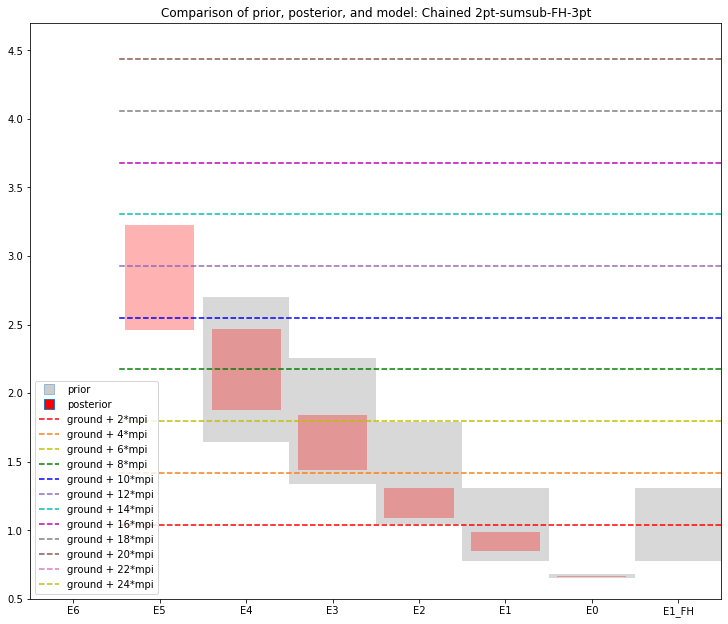

In [53]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Chained 2pt-sumsub-FH-3pt")
ax.set_xlim([6.5, -1.5])
ax.set_xticks([6, 5, 4, 3, 2, 1, 0, -1])
ax.set_xticklabels(["E6", "E5", "E4", "E3", "E2", "E1", "E0", "E{}_FH".format(num_states_FH - 1)])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 4.7])
plt.show()

#### g_A_{00} =               
#### g_V_{00} = 

In [54]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)

gA_00 =  1.2652161958776278 +/- 0.007030702362023504
gV_00 =  1.0196724950758804 +/- 0.0006510448052574713


In [55]:
# tau 2, FH
num_zs = 4
# Now, retrieve posteriors
posterior_file = open("Final(3pt)_tau2_withFH_out.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])

posterior_FH_xval = np.array([-1])
posterior_FH_xval_err = np.array([[0.5], [0.5]])
E_FH_posterior = posteriors['E{}'.format(num_states_FH-2)]+posteriors['FH_dEmax']
posterior_FH_yval = np.array([E_FH_posterior.mean])
posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])




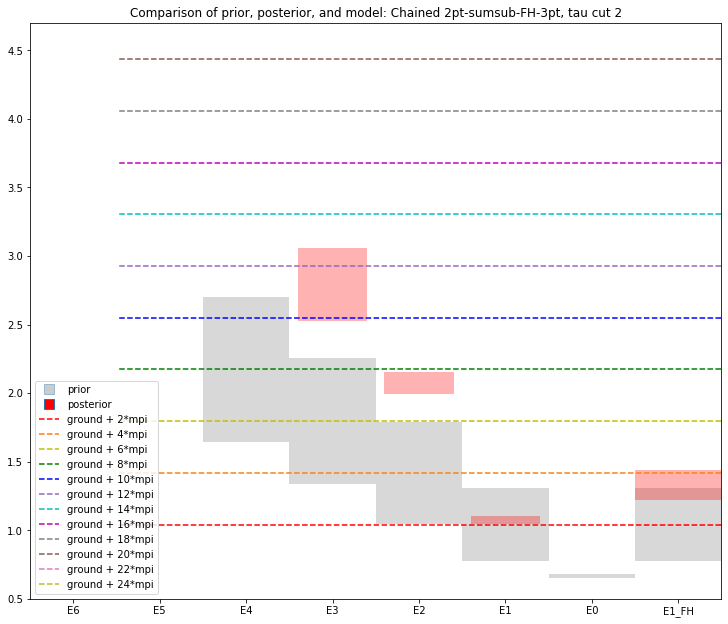

In [56]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Chained 2pt-sumsub-FH-3pt, tau cut 2")
ax.set_xlim([6.5, -1.5])
ax.set_xticks([6, 5, 4, 3, 2, 1, 0, -1])
ax.set_xticklabels(["E6", "E5", "E4", "E3", "E2", "E1", "E0", "E{}_FH".format(num_states_FH - 1)])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 4.7])
plt.show()

#### g_A_{00} =               
#### g_V_{00} = 

In [57]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)

gA_00 =  1.23571281342936 +/- 0.012373388713274414
gV_00 =  1.0198068084348222 +/- 0.0014042834405592044


In [63]:
# 2 point and 3-point
num_zs = 5

priors = gv.BufferDict()

priors['E0'] = gv.gvar(0.665, 0.015)
# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = priors['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0
    energyvals[k] = energyvals[k-1] + dEvals[k-1]
    
for k in range(1, num_zs):
    priors['log(dE{})'.format(k)] = gv.gvar(np.log(dEvals[k-1]), 0.7)
    
#priors['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)
    
energies_prior = gv.BufferDict()

energies_prior['E0'] = priors['E0']
for k in range(1, num_zs):
    energies_prior['E{}'.format(k)] = Ei(k, priors)
    
prior_xval = np.array([k for k in range(num_zs)])
prior_xval_err = np.array([[0.5 for k in range(num_zs)], [0.5 for k in range(num_zs)]])
prior_yval = np.array([energies_prior['E{}'.format(k)].mean for k in range(num_zs)])
prior_yval_err = np.array([[energies_prior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_prior['E{}'.format(k)].sdev for k in range(num_zs)]])


In [64]:

posterior_file = open("simul2pt3pt_n5_out.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])


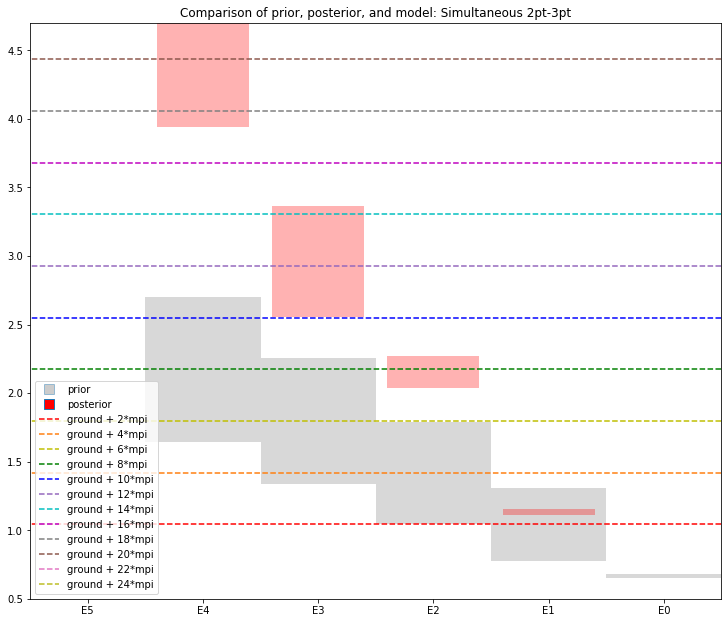

In [65]:

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Simultaneous 2pt-3pt")
ax.set_xlim([5.5, -0.5])
ax.set_xticks([5, 4, 3, 2, 1, 0])
ax.set_xticklabels(["E5", "E4", "E3", "E2", "E1", "E0"])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 4.7])
plt.show()



#### g_A_{00} = 1.22 +/- 0.01                
#### g_V_{00} = 1.019 +/- 0.002

In [66]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)

gA_00 =  1.2205517703423125 +/- 0.009947005010779863
gV_00 =  1.019427411938844 +/- 0.0016951480261029816


In [67]:
# Chained 2-point-3point fit
num_zs = 5

priors = gv.BufferDict()

priors['E0'] = gv.gvar(0.665, 0.015)
# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = priors['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0
    energyvals[k] = energyvals[k-1] + dEvals[k-1]
    
for k in range(1, num_zs):
    priors['log(dE{})'.format(k)] = gv.gvar(np.log(dEvals[k-1]), 0.7)
    
#priors['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)
    
energies_prior = gv.BufferDict()

energies_prior['E0'] = priors['E0']
for k in range(1, num_zs):
    energies_prior['E{}'.format(k)] = Ei(k, priors)
    
prior_xval = np.array([k for k in range(num_zs)])
prior_xval_err = np.array([[0.5 for k in range(num_zs)], [0.5 for k in range(num_zs)]])
prior_yval = np.array([energies_prior['E{}'.format(k)].mean for k in range(num_zs)])
prior_yval_err = np.array([[energies_prior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_prior['E{}'.format(k)].sdev for k in range(num_zs)]])





In [68]:
posterior_file = open("chained_2pt_3pt_Final.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])


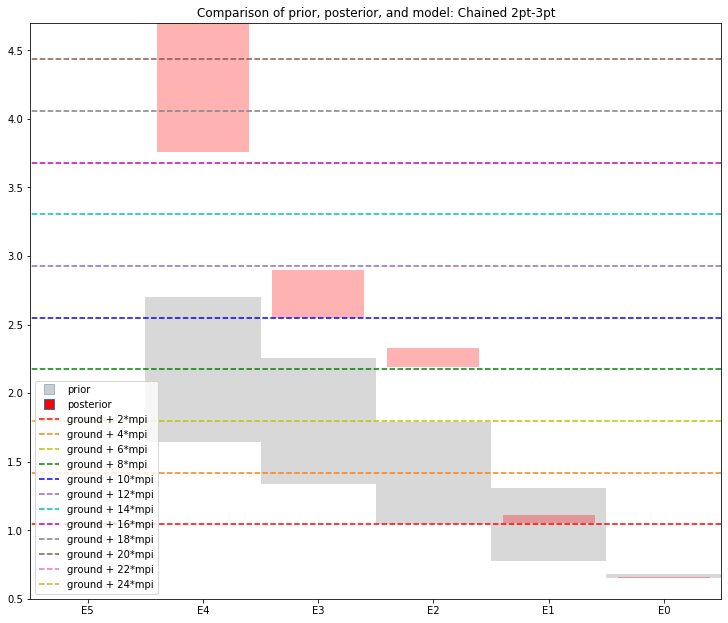

In [69]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Chained 2pt-3pt")
ax.set_xlim([5.5, -0.5])
ax.set_xticks([5, 4, 3, 2, 1, 0])
ax.set_xticklabels(["E5", "E4", "E3", "E2", "E1", "E0"])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 4.7])
plt.show()



#### g_A_{00} = 1.23 +/- 0.01               
#### g_V_{00} = 1.019 +/- 0.004

In [70]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)

gA_00 =  1.2261708352624217 +/- 0.011186862427284647
gV_00 =  1.019456291951187 +/- 0.0039693032917995676


In [37]:
# Now, set priors
num_zs = 7
#num_states_FH = 2

priors = gv.BufferDict()

priors['E0'] = gv.gvar(0.665, 0.015)
# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = priors['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0
    energyvals[k] = energyvals[k-1] + dEvals[k-1]
    
for k in range(1, num_zs):
    priors['log(dE{})'.format(k)] = gv.gvar(np.log(dEvals[k-1]), 0.7)
    
#priors['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)
    
energies_prior = gv.BufferDict()

energies_prior['E0'] = priors['E0']
for k in range(1, num_zs):
    energies_prior['E{}'.format(k)] = Ei(k, priors)
    
prior_xval = np.array([k for k in range(num_zs)])
prior_xval_err = np.array([[0.5 for k in range(num_zs)], [0.5 for k in range(num_zs)]])
prior_yval = np.array([energies_prior['E{}'.format(k)].mean for k in range(num_zs)])
prior_yval_err = np.array([[energies_prior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_prior['E{}'.format(k)].sdev for k in range(num_zs)]])


In [38]:
posterior_file = open("3pt_individual_out.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])



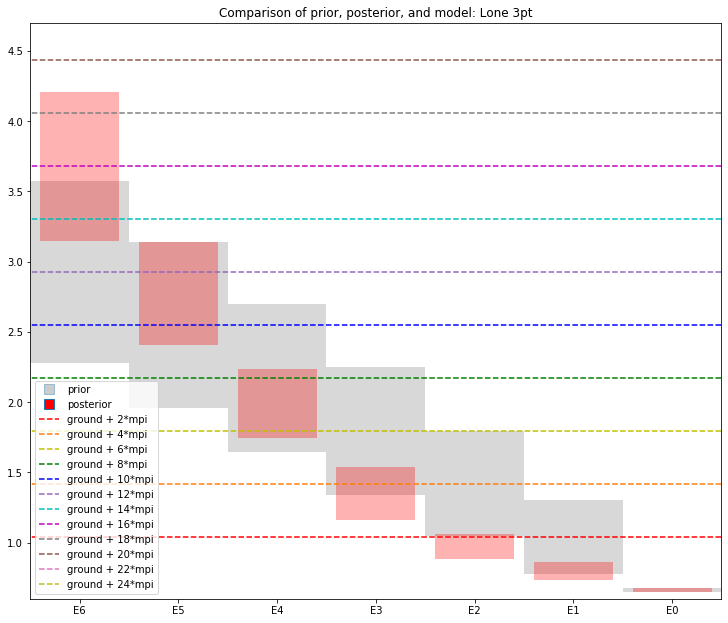

In [40]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Lone 3pt")
ax.set_xlim([6.5, -0.5])
ax.set_xticks([6, 5, 4, 3, 2, 1, 0])
ax.set_xticklabels(["E6", "E5", "E4", "E3", "E2", "E1", "E0"])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.6, 4.7])
plt.show()




#### g_A_{00} = 1.28 +/- 0.08               
#### g_V_{00} = 1.05 +/- 0.06

In [74]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)

gA_00 =  1.2784836375410473 +/- 0.07508390549089405
gV_00 =  1.0461761259872415 +/- 0.060699083325602116


In [115]:
# Now, lone Feynman-Hellman
num_states_FH = 2

priors = gv.BufferDict()

priors['E0'] = gv.gvar(0.665, 0.015)
# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_states_FH)
dEvals = np.array([None]*(num_states_FH - 1))

#E0_errbar = 0.8
energyvals[0] = priors['E0'].mean
for k in range(1, num_states_FH):
    dEvals[k-1] = dE0
    energyvals[k] = energyvals[k-1] + dEvals[k-1]
    
for k in range(1, num_states_FH - 1):
    priors['log(dE{})'.format(k)] = gv.gvar(np.log(dEvals[k-1]), 0.7)
    
priors['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)
    
energies_prior = gv.BufferDict()

energies_prior['E0'] = priors['E0']
for k in range(1, num_states_FH - 1):
    energies_prior['E{}'.format(k)] = Ei(k, priors)
    
prior_xval = np.array([k for k in range(num_states_FH - 1)])
prior_xval_err = np.array([[0.5 for k in range(num_states_FH - 1)], [0.5 for k in range(num_states_FH - 1)]])
prior_yval = np.array([energies_prior['E{}'.format(k)].mean for k in range(num_states_FH - 1)])
prior_yval_err = np.array([[energies_prior['E{}'.format(k)].sdev for k in range(num_states_FH - 1)], [energies_prior['E{}'.format(k)].sdev for k in range(num_states_FH - 1)]])

prior_FH_xval = np.array([-1])
prior_FH_xval_err = np.array([[0.5], [0.5]])
E_FH_prior = priors['E{}'.format(num_states_FH-2)]+priors['FH_dEmax']
prior_FH_yval = np.array([E_FH_prior.mean])
prior_FH_yval_err = np.array([[E_FH_prior.sdev], [E_FH_prior.sdev]])

prior_xval = np.append(prior_xval, prior_FH_xval, axis=0)
prior_xval_err = np.array([np.append(prior_xval_err[0], prior_FH_xval_err[0]), np.append(prior_xval_err[1], prior_FH_xval_err[1])])
#prior_xval_err[0] = np.append(prior_xval_err[0], prior_FH_xval_err[0])
#prior_xval_err[1] = np.append(prior_xval_err[1], prior_FH_xval_err[1])
prior_yval = np.append(prior_yval, prior_FH_yval, axis=0)
prior_yval_err = np.array([np.append(prior_yval_err[0], prior_FH_yval_err[0]), np.append(prior_yval_err[1], prior_FH_yval_err[1])])

In [116]:
# Now, retrieve posteriors
posterior_file = open("FH_individual_out.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_states_FH - 1):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_states_FH - 1)])
posterior_xval_err = np.array([[0.4 for k in range(num_states_FH - 1)], [0.4 for k in range(num_states_FH - 1)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_states_FH - 1)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_states_FH - 1)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_states_FH - 1)]])

posterior_FH_xval = np.array([-1])
posterior_FH_xval_err = np.array([[0.5], [0.5]])
E_FH_posterior = posteriors['E{}'.format(num_states_FH-2)]+posteriors['FH_dEmax']
posterior_FH_yval = np.array([E_FH_posterior.mean])
posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])




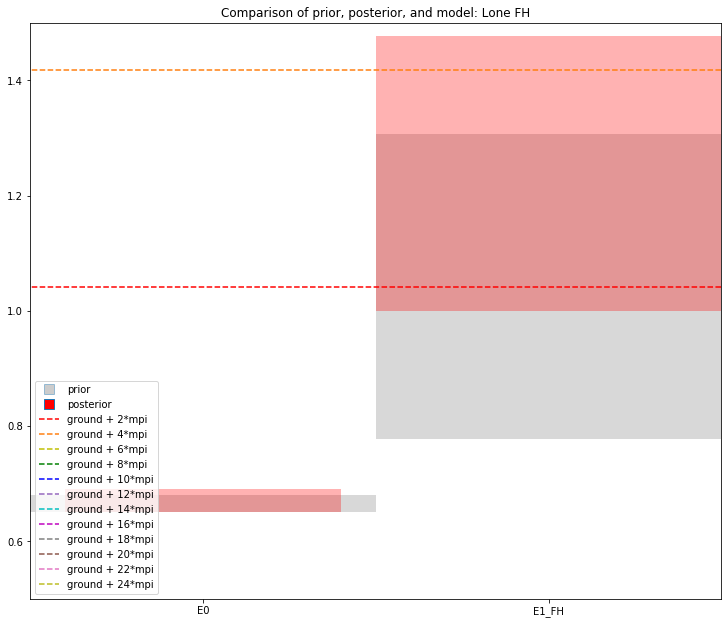

In [117]:

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Lone FH")
ax.set_xlim([0.5, -1.5])
ax.set_xticks([0, -1])
ax.set_xticklabels(["E0", "E{}_FH".format(num_states_FH - 1)])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 1.5])
plt.show()



#### g_A_{00} = 1.26 +/- 0.03               
#### g_V_{00} = 1.02 +/- 0.02

In [105]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)

gA_00 =  1.257330465890057 +/- 0.027235947681719157
gV_00 =  1.0223164599008554 +/- 0.017185940817929225


In [106]:
# Simultaneous 2-point-FH fit
# Now, set priors
num_zs = 2
num_states_FH = 2

priors = gv.BufferDict()

priors['E0'] = gv.gvar(0.665, 0.015)
# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = priors['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0
    energyvals[k] = energyvals[k-1] + dEvals[k-1]
    
for k in range(1, num_zs):
    priors['log(dE{})'.format(k)] = gv.gvar(np.log(dEvals[k-1]), 0.7)
    
priors['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)
    
energies_prior = gv.BufferDict()

energies_prior['E0'] = priors['E0']
for k in range(1, num_zs):
    energies_prior['E{}'.format(k)] = Ei(k, priors)
    
prior_xval = np.array([k for k in range(num_zs)])
prior_xval_err = np.array([[0.5 for k in range(num_zs)], [0.5 for k in range(num_zs)]])
prior_yval = np.array([energies_prior['E{}'.format(k)].mean for k in range(num_zs)])
prior_yval_err = np.array([[energies_prior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_prior['E{}'.format(k)].sdev for k in range(num_zs)]])

#prior_FH_xval = np.array([-1])
#prior_FH_xval_err = np.array([[0.5], [0.5]])
#E_FH_prior = priors['E{}'.format(num_states_FH-2)]+priors['FH_dEmax']
#prior_FH_yval = np.array([E_FH_prior.mean])
#prior_FH_yval_err = np.array([[E_FH_prior.sdev], [E_FH_prior.sdev]])

#prior_xval = np.append(prior_xval, prior_FH_xval, axis=0)
#prior_xval_err = np.array([np.append(prior_xval_err[0], prior_FH_xval_err[0]), np.append(prior_xval_err[1], prior_FH_xval_err[1])])
#prior_xval_err[0] = np.append(prior_xval_err[0], prior_FH_xval_err[0])
#prior_xval_err[1] = np.append(prior_xval_err[1], prior_FH_xval_err[1])
#prior_yval = np.append(prior_yval, prior_FH_yval, axis=0)
#prior_yval_err = np.array([np.append(prior_yval_err[0], prior_FH_yval_err[0]), np.append(prior_yval_err[1], prior_FH_yval_err[1])])

In [107]:
# Now, retrieve posteriors
posterior_file = open("simul2ptFH_n5_nFH3_out.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])

#posterior_FH_xval = np.array([-1])
#posterior_FH_xval_err = np.array([[0.5], [0.5]])
#E_FH_posterior = posteriors['E{}'.format(num_states_FH-2)]+posteriors['FH_dEmax']
#posterior_FH_yval = np.array([E_FH_posterior.mean])
#posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

#posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
#posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
#posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
#posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])
#posteriors

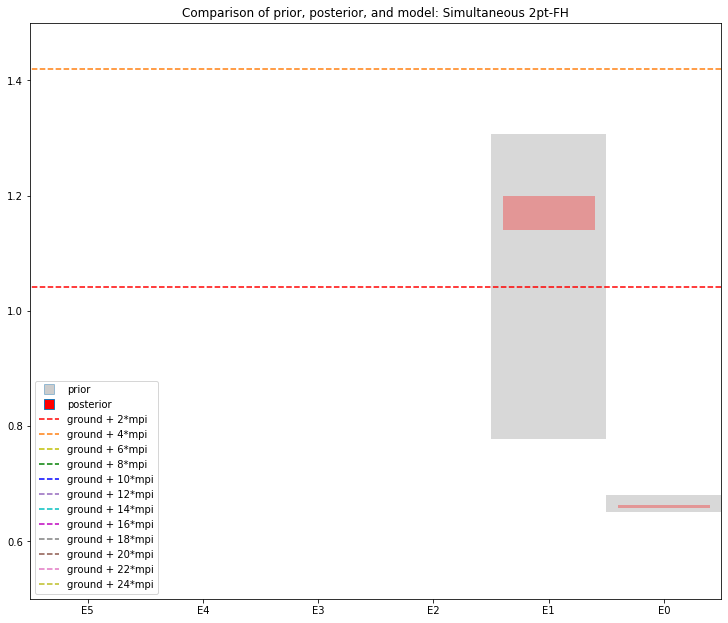

In [108]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Simultaneous 2pt-FH")
ax.set_xlim([5.5, -0.5])
ax.set_xticks([5, 4, 3, 2, 1, 0])
ax.set_xticklabels(["E5", "E4", "E3", "E2", "E1", "E0"])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 1.5])
plt.show()


#### g_A_{00} = 1.26 +/- 0.02               
#### g_V_{00} = 1.03 +/- 0.01

In [109]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)


gA_00 =  1.2612488932334986 +/- 0.016272952484807035
gV_00 =  1.0253446638963877 +/- 0.011218449492029174


In [110]:
# Chained 2point- FH
num_zs = 2
num_states_FH = 2

priors = gv.BufferDict()

priors['E0'] = gv.gvar(0.665, 0.015)
# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = priors['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0
    energyvals[k] = energyvals[k-1] + dEvals[k-1]
    
for k in range(1, num_zs):
    priors['log(dE{})'.format(k)] = gv.gvar(np.log(dEvals[k-1]), 0.7)
    
priors['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)
    
energies_prior = gv.BufferDict()

energies_prior['E0'] = priors['E0']
for k in range(1, num_zs):
    energies_prior['E{}'.format(k)] = Ei(k, priors)
    
prior_xval = np.array([k for k in range(num_zs)])
prior_xval_err = np.array([[0.5 for k in range(num_zs)], [0.5 for k in range(num_zs)]])
prior_yval = np.array([energies_prior['E{}'.format(k)].mean for k in range(num_zs)])
prior_yval_err = np.array([[energies_prior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_prior['E{}'.format(k)].sdev for k in range(num_zs)]])

#prior_FH_xval = np.array([-1])
#prior_FH_xval_err = np.array([[0.5], [0.5]])
#E_FH_prior = priors['E{}'.format(num_states_FH-2)]+priors['FH_dEmax']
#prior_FH_yval = np.array([E_FH_prior.mean])
#prior_FH_yval_err = np.array([[E_FH_prior.sdev], [E_FH_prior.sdev]])

#prior_xval = np.append(prior_xval, prior_FH_xval, axis=0)
#prior_xval_err = np.array([np.append(prior_xval_err[0], prior_FH_xval_err[0]), np.append(prior_xval_err[1], prior_FH_xval_err[1])])
#prior_xval_err[0] = np.append(prior_xval_err[0], prior_FH_xval_err[0])
#prior_xval_err[1] = np.append(prior_xval_err[1], prior_FH_xval_err[1])
#prior_yval = np.append(prior_yval, prior_FH_yval, axis=0)
#prior_yval_err = np.array([np.append(prior_yval_err[0], prior_FH_yval_err[0]), np.append(prior_yval_err[1], prior_FH_yval_err[1])])

In [111]:
# Now, retrieve posteriors
posterior_file = open("chained_2pt_FH_Final.obj", 'rb')
posteriors = pickle.load(posterior_file)
posterior_file.close()

energies_posterior = gv.BufferDict()

energies_posterior['E0'] = posteriors['E0']
for k in range(1, num_zs):
    energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
posterior_xval = np.array([k for k in range(num_zs)])
posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])

#posterior_FH_xval = np.array([-1])
#posterior_FH_xval_err = np.array([[0.5], [0.5]])
#E_FH_posterior = posteriors['E{}'.format(num_states_FH-2)]+posteriors['FH_dEmax']
#posterior_FH_yval = np.array([E_FH_posterior.mean])
#posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

#posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
#posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
#posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
#posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])



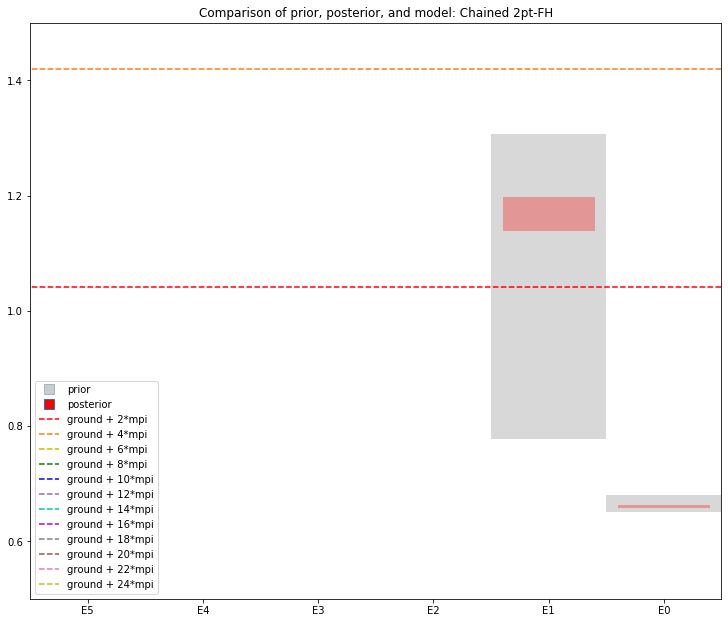

In [112]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

#plots_patches = []
for i in range(1, num_models + 1):
    #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
    ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

ax.set_title("Comparison of prior, posterior, and model: Chained 2pt-FH")
ax.set_xlim([5.5, -0.5])
ax.set_xticks([5, 4, 3, 2, 1, 0])
ax.set_xticklabels(["E5", "E4", "E3", "E2", "E1", "E0"])

priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]

makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey', 'grey', 'grey', 'grey', 'grey', 'grey'], legendlabel="prior")
makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red', 'red', 'red', 'red', 'red', 'red'], legendlabel="posterior")

legend_objects = [priorpatch, posteriorpatch]
legend_labels = ["prior", "posterior"]
for i in range(1, num_models + 1):
    legend_objects.append(plots_patch[i])
    legend_labels.append(labels[i])

plt.legend()
plt.legend(legend_objects, legend_labels)
plt.ylim([0.5, 1.5])
plt.show()



#### g_A_{00} = 1.26 +/- 0.02               
#### g_V_{00} = 1.03 +/- 0.01

In [113]:
print("gA_00 = ", posteriors['gA3_00'].mean, "+/-", posteriors['gA3_00'].sdev)
print("gV_00 = ", posteriors['gV4_00'].mean, "+/-", posteriors['gV4_00'].sdev)

gA_00 =  1.2629617568122533 +/- 0.016479507642983067
gV_00 =  1.0269856405195459 +/- 0.011379059584477099
